# _Moneyballing Fantasy Premier League Football_
# Clustering Analysis

As mentioned in previous workbooks, success in FPL is often driven by finding budget options, who are just as good as the expensive superstar players that are more commonly picked.

To this end, we can create 'clusters' of players, which will allow us to see which players have similar underlying statistics. Thus, we would be able to identify an expensive player (who, perhaps, we can not afford to have in our team), and see which cheaper players belong to the same cluster.

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import pdpipe as pdp
import numpy as np

#SQL
import sqlite3
#Including custom functions, stored elsewhere in the repo
from PythonFunctions.sqlfunctions import *

#For data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#For clustering analysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#For evaluating clusters
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, ward

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

We bring in data at a player gameweek level (we can aggregate this back up again as required for the clustering).

In [2]:
#Connect to the database 'fpl.db' (fantasy premier league!)
conn = sqlite3.connect('Data/fpl.db')
#Instantiate a cursor
c = conn.cursor()

In [3]:
df_players = sql('SELECT * FROM PlayersBasic', c)
df_players.head()

,PlayerID,PlayerCode,FirstName,WebName,Team,Position,CommentName
PlayersBasicID,,,,,,,
1,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
2,2,98745,Hector,Bellerin,Arsenal,DEF,Hector Bellerin
3,3,111457,Sead,Kolasinac,Arsenal,DEF,Sead Kolasinac
4,4,154043,Ainsley,Maitland-Niles,Arsenal,DEF,Ainsley Maitland-Niles
5,5,39476,Sokratis,Sokratis,Arsenal,DEF,Sokratis


In [4]:
df = sql('SELECT * FROM PlayerMatchesDetail', c)
df.head()

,TableIndex,Player,GameWeek,Minutes,ForTeam,AgainstTeam,RelativeStrenth,Goals,ShotsOnTarget,ShotsInBox,...,ShotsLeft,ShotsRight,GoalAssists,ShotOnTargetCreated,ShotInBoxCreated,CloseShotCreated,TotalShotCreated,CreatedCentre,CreatedLeft,CreatedRight
PlayerMatchesDetailID,,,,,,,,,,,,,,,,,,,,,
1,0,Alisson,1,90,Liverpool,Norwich City,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Virgil van Dijk,1,90,Liverpool,Norwich City,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2,Joseph Gomez,1,90,Liverpool,Norwich City,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,Andrew Robertson,1,90,Liverpool,Norwich City,3,0,0,1,...,1,0,0,0,1,0,1,0,1,0
5,4,Trent Alexander-Arnold,1,90,Liverpool,Norwich City,3,0,1,0,...,0,0,1,2,2,3,3,2,0,0


## Preparing the dataset

What data do we want to cluster on? Certainly we want to consider the attacking stats that we have, though looking at it on a match by match basis might not be right - remember, we want to cluster specific players. However, we do lose the granularity of the match by match view. We can compromise by looking at segments of the season - e.g. gameweek 1-8, 9-16, 17-26, etc. Thus, if a player was performing very well early in the season, we can look at which players are playing like that now.

To prep the dataset, we can use the pdpipe package to generate a pipeline to manage the dataset.

As a reminder - our pipeline should do the following to the input dataset:

* Drop extraneous columns
* Create a new column that categorises the gameweek into buckets
* Groupby player and gameweek group (summing across statistics)
* Divide statistics by the total minutes played
* Collapse the multi-index
* Perform standard scaling

In [5]:
#Firstly, define the gameweek grouper
def gwgrouper(gw):
    if gw <= 8:
        return '01-08'
    elif gw <= 16:
        return '08-18'
    else:
        return '19-26'

Let's now build out the pipeline.

In [6]:
#Drop columns
pipeline = pdp.ColDrop(['TableIndex','ForTeam', 'AgainstTeam','RelativeStrenth'])
#Create a new column that categorises the gameweek into buckets
pipeline += pdp.ApplyByCols('GameWeek', gwgrouper)

#Groupby player and gameweek group (summing across statistics)
df_cluster = pipeline(df).groupby(['Player','GameWeek']).sum()
df_cluster.index = df_cluster.index.map('_'.join)

#Drop rows where players are barely playing
df_cluster = df_cluster.loc[df_cluster['Minutes']>180]

#Now convert stats into 'stats per 90 minutes'
for col in df_cluster.columns[1:]:
    df_cluster[col] = 90*df_cluster[col]/df_cluster['Minutes']
    
#Drop rows with NAs
df_cluster.dropna(inplace=True)
    
#Perform standard scaling across columns
scaler = StandardScaler()
df_cluster = scaler.fit_transform(df_cluster)

## Cluster Analysis

### K-Means Clustering

There are two types of clustering algorithm that we can use - the first of which is k means.

This works by randomly choosing k 'centre' points in hyperspace, then assigning each datapoint to the closest centre. The centres of the k clusters are re-calculated, and datapoints are redistributed to their new nearest centres. This continues iteratively until no re-allocation occurs.

We can try different values of k, and use the Calinski Harabasz score as a measure of cluster quality.

In [7]:
#Declare k_values
k_values = range(3,50)

#Initiate some empty lists for the dataset
km_preds = []
km_cs_scores = []

#Iterate through these
for k in k_values:
    #Instantiate and run a KMeans algorithm
    k_means = KMeans(n_clusters=k)
    k_means.fit(df_cluster)
    
    #Store the predicted labels
    km_preds.append(k_means.predict(df_cluster))
    
    #Evaluate and store the clusters' Calinski Harabasz score
    cs_score = calinski_harabasz_score(df_cluster, k_means.labels_)
    km_cs_scores.append(cs_score)

### HA Clustering

Let's try a similar approach, but with HAC instead.

In [8]:
#Initiate some empty lists for the dataset
hac_preds = []
hac_cs_scores = []

#Iterate through the k values we'd previously defined
for k in k_values:
    #Instantiate and run a HAC algorithm
    agg_clust = AgglomerativeClustering(n_clusters=k)
    preds = agg_clust.fit_predict(df_cluster)
    
    #Store the predicted labels
    hac_preds.append(preds)
    
    #Evaluate and store the clusters' Calinski Harabasz score
    cs_score = calinski_harabasz_score(df_cluster, preds)
    hac_cs_scores.append(cs_score)

We can now visualise how these two different algorithms performed, according to the CS scores for each.

Interestingly, it seems like K-Means produces better results for each level of k.

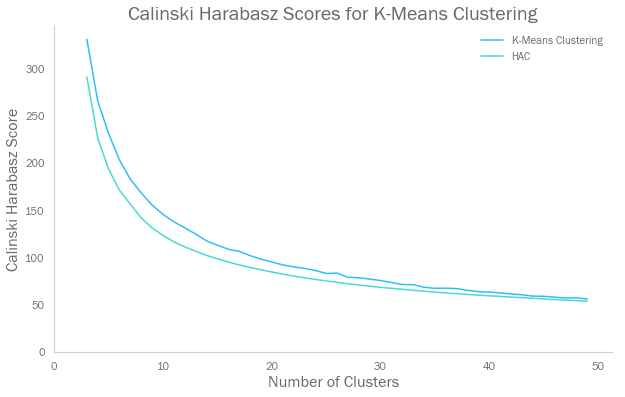

In [9]:
plt.figure(figsize=(10,6))

alpha = 1

plt.plot(k_values, km_cs_scores, alpha=alpha,
            label='K-Means Clustering')

plt.plot(k_values, hac_cs_scores, alpha=alpha,
            label='HAC')

plt.xlim(0)
plt.ylim(0)

plt.legend(frameon=False)

plt.title('Calinski Harabasz Scores for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score');

We can create a new dataframe that considers the results of the clustering (note, we use K-Means, k=20).

In [10]:
max(km_preds[8])

10

In [11]:
#Groupby player and gameweek group (summing across statistics)
df_results = pipeline(df).groupby(['Player','GameWeek']).sum()
df_results.index = df_results.index.map('_'.join)

#Now convert stats into 'stats per 90 minutes'
for col in df_results.columns[1:]:
    df_results[col] = 90*df_results[col]/df_results['Minutes']
    
#Drop rows with NAs
df_results.dropna(inplace=True)

#Drop rows where players are barely playing
df_results = df_results.loc[df_results['Minutes']>180]

df_results['Cluster'] = km_preds[8]

df_results.head()

,Minutes,Goals,ShotsOnTarget,ShotsInBox,CloseShots,TotalShots,ShotsCentre,ShotsLeft,ShotsRight,GoalAssists,ShotOnTargetCreated,ShotInBoxCreated,CloseShotCreated,TotalShotCreated,CreatedCentre,CreatedLeft,CreatedRight,Cluster
Aaron Connolly_08-18,410,0.000000,0.658537,1.536585,0.878049,2.195122,0.878049,0.219512,0.439024,0.0,0.219512,0.000000,0.219512,0.219512,0.000000,0.219512,0.0,1
Aaron Connolly_19-26,257,0.000000,0.700389,0.700389,1.050584,2.101167,0.700389,0.000000,0.350195,0.0,0.000000,0.000000,0.000000,0.350195,0.000000,0.000000,0.0,1
Aaron Cresswell_01-08,360,0.500000,0.500000,0.250000,0.500000,1.250000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7
Aaron Cresswell_08-18,630,0.142857,0.428571,0.428571,0.428571,0.857143,0.285714,0.142857,0.000000,0.0,0.000000,0.142857,0.000000,0.428571,0.142857,0.000000,0.0,8
Aaron Cresswell_19-26,720,0.000000,0.000000,0.125000,0.000000,0.250000,0.125000,0.000000,0.000000,0.0,0.500000,1.125000,0.500000,1.375000,1.000000,0.125000,0.0,3


Let's get a sense of how the different groups performed.

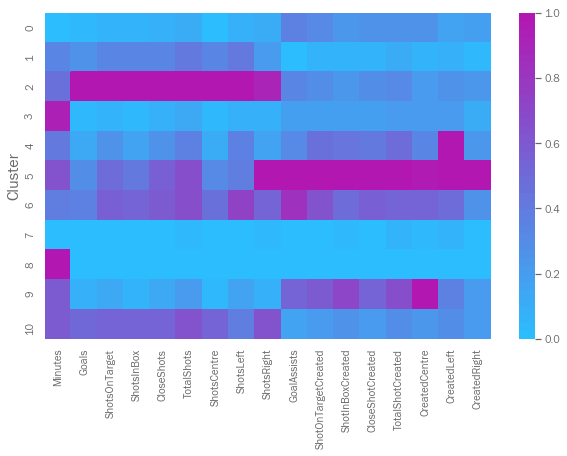

In [12]:
cluster_means = df_results.groupby('Cluster').mean()
mmscaler = MinMaxScaler()
scaled_cluster_means = pd.DataFrame(mmscaler.fit_transform(cluster_means),
                                    columns=cluster_means.columns,
                                    index=cluster_means.index)

plt.figure(figsize=(10,6))
sns.heatmap(scaled_cluster_means, cmap=CB91_Grad_BP);

In [13]:
df_results.loc[df_results['Cluster']==6]

,Minutes,Goals,ShotsOnTarget,ShotsInBox,CloseShots,TotalShots,ShotsCentre,ShotsLeft,ShotsRight,GoalAssists,ShotOnTargetCreated,ShotInBoxCreated,CloseShotCreated,TotalShotCreated,CreatedCentre,CreatedLeft,CreatedRight,Cluster
Adama Traore_19-26,753,0.239044,0.717131,1.075697,0.836653,2.031873,0.119522,0.000000,0.956175,0.478088,1.075697,1.434263,1.075697,2.151394,1.075697,0.000000,0.478088,6
Allan Saint-Maximin_19-26,259,0.000000,1.042471,0.694981,1.389961,2.779923,0.000000,1.042471,0.000000,0.347490,0.347490,1.389961,0.694981,2.084942,1.389961,0.000000,0.000000,6
Andriy Yarmolenko_08-18,357,0.000000,0.756303,1.008403,1.260504,2.016807,0.252101,0.252101,0.756303,0.252101,1.008403,1.512605,1.512605,1.512605,1.260504,0.252101,0.000000,6
Andy Carroll_19-26,282,0.000000,0.319149,2.553191,0.638298,2.872340,2.234043,0.319149,0.000000,0.319149,0.638298,1.276596,0.957447,1.595745,1.276596,0.000000,0.000000,6
Anthony Martial_08-18,511,0.352250,1.937378,1.409002,2.289628,3.170254,0.352250,0.528376,0.528376,0.352250,0.704501,0.880626,1.056751,1.056751,0.528376,0.176125,0.176125,6
Anwar El Ghazi_01-08,509,0.353635,1.414538,1.060904,1.768173,3.005894,0.530452,0.176817,0.353635,0.530452,0.884086,0.884086,1.060904,1.414538,0.707269,0.000000,0.176817,6
Ayoze Perez_19-26,562,0.480427,0.960854,0.960854,1.120996,1.601423,0.800712,0.160142,0.000000,0.480427,1.441281,1.281139,1.441281,1.761566,1.120996,0.160142,0.000000,6
Bernardo Silva_08-18,531,0.169492,0.847458,1.694915,0.847458,1.864407,0.847458,0.169492,0.677966,0.508475,1.186441,1.355932,1.355932,2.542373,0.677966,0.338983,0.338983,6
Bukayo Saka_01-08,209,0.000000,0.430622,1.291866,0.430622,1.722488,0.861244,0.430622,0.000000,0.430622,0.430622,1.291866,1.291866,2.153110,0.861244,0.000000,0.430622,6
Christian Benteke_01-08,237,0.000000,1.139241,1.139241,1.518987,1.898734,1.139241,0.000000,0.379747,0.000000,1.139241,1.518987,1.139241,1.898734,1.139241,0.379747,0.000000,6
